In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Explore here

In [3]:
#CARGAR DATOS Y EDA 

#Importar el csv:

url= "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"

df= pd.read_csv(url)
#Creo 4 columnas, una para cada región y elimino la columna región 
df_dummies = pd.get_dummies(df['region'], prefix='region')
df = pd.concat([df, df_dummies], axis=1)
df.head()
df = df.drop('region', axis=1)

#Eliminar duplicados:
df.drop_duplicates()
df.head()

#Convierto los valores cualitativos en cuantitativos:

le= LabelEncoder()

df["sex"]= le.fit_transform(df["sex"])
df["smoker"]= le.fit_transform(df["smoker"])
df["region_northeast"]= le.fit_transform(df["region_northeast"])
df["region_northwest"]= le.fit_transform(df["region_northwest"])
df["region_southeast"]= le.fit_transform(df["region_southeast"])
df["region_southwest"]= le.fit_transform(df["region_southwest"])


In [4]:
#TRAIN Y TEST

X = df.drop("charges", axis=1) 
y = df["charges"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#ESCALADO 
scaler = MinMaxScaler()
X_train_esc = scaler.fit_transform(X_train)
X_test_esc = scaler.transform(X_test)

X_train_esc= pd.DataFrame(X_train_esc, index= X_train.index, columns=X_train.columns)
X_train_esc.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
560,0.608696,0.0,0.107345,0.4,0.0,0.0,1.0,0.0,0.0
1285,0.630435,0.0,0.224913,0.0,0.0,1.0,0.0,0.0,0.0
1142,0.739130,0.0,0.239440,0.0,0.0,0.0,0.0,1.0,0.0
969,0.456522,0.0,0.493947,1.0,0.0,0.0,0.0,1.0,0.0
486,0.782609,0.0,0.148238,0.6,0.0,0.0,1.0,0.0,0.0


In [6]:
X_test_esc= pd.DataFrame(X_test_esc, index= X_test.index, columns=X_test.columns)
X_test_esc.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
764,0.586957,0.0,0.247915,0.4,0.0,1.0,0.0,0.0,0.0
887,0.391304,0.0,0.378262,0.0,0.0,0.0,1.0,0.0,0.0
890,1.000000,0.0,0.293920,0.0,1.0,0.0,1.0,0.0,0.0
1293,0.608696,1.0,0.263250,0.6,0.0,0.0,1.0,0.0,0.0
259,0.021739,1.0,0.429379,0.0,1.0,0.0,1.0,0.0,0.0


In [7]:
selection_model = SelectKBest(score_func=mutual_info_regression, k=5)
selection_model.fit(X_train, y_train)
selec = selection_model.get_support()

X_train_sel = pd.DataFrame(selection_model.transform(X_train_esc), columns = X_train_esc.columns.values[selec])
X_test_sel = pd.DataFrame(selection_model.transform(X_test_esc), columns = X_test_esc.columns.values[selec])
X_train_sel.head()

#Uso f-ANOVA porque la variable objeto es continua y no funciona asi que cambio a mutual_info_regression

,age,sex,bmi,children,smoker
0,0.608696,0.0,0.107345,0.4,0.0
1,0.630435,0.0,0.224913,0.0,0.0
2,0.739130,0.0,0.239440,0.0,0.0
3,0.456522,0.0,0.493947,1.0,0.0
4,0.782609,0.0,0.148238,0.6,0.0


In [8]:
X_test_sel.head()


,age,sex,bmi,children,smoker
0,0.586957,0.0,0.247915,0.4,0.0
1,0.391304,0.0,0.378262,0.0,0.0
2,1.000000,0.0,0.293920,0.0,1.0
3,0.608696,1.0,0.263250,0.6,0.0
4,0.021739,1.0,0.429379,0.0,1.0


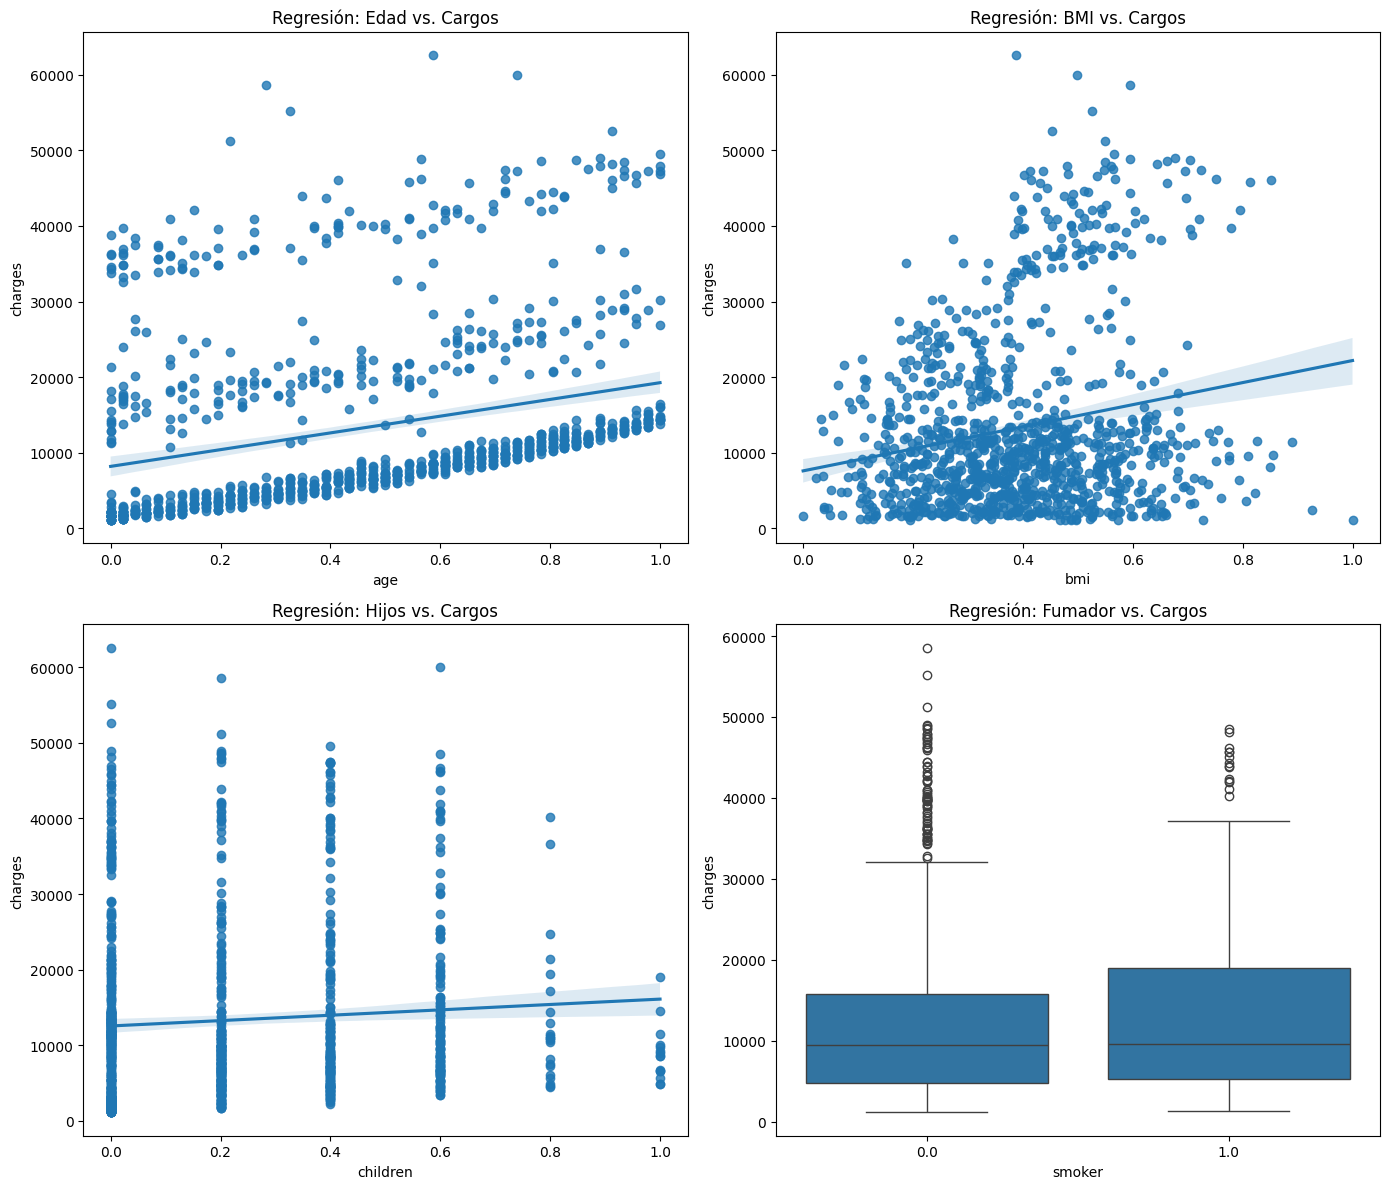

In [9]:

# Visualización de regresión
fig, axis = plt.subplots(2, 2, figsize=(14, 12))

sns.regplot(x=X_train_sel['age'], y=y_train, ax=axis[0, 0])
axis[0, 0].set_title('Regresión: Edad vs. Cargos')

sns.regplot(x=X_train_sel['bmi'], y=y_train, ax=axis[0, 1])
axis[0, 1].set_title('Regresión: BMI vs. Cargos')

sns.regplot(x=X_train_sel['children'], y=y_train, ax=axis[1, 0])
axis[1, 0].set_title('Regresión: Hijos vs. Cargos')

sns.boxplot(x=X_train_sel['smoker'], y=y_train, ax=axis[1, 1])
axis[1, 1].set_title('Regresión: Fumador vs. Cargos')

plt.tight_layout()
plt.show()


In [10]:
model = LinearRegression()
model.fit(X_train_sel, y_train)

y_pred = model.predict(X_test_sel)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.6f}")
print(f"R2: {r2:.4f}")

#El valor de R2 es bueno pero el de MSE es altísimo 

MSE: 33979257.050808
R2: 0.7811


In [11]:
#Resumen de correlación de datos
X = df.drop(["charges", "region_northeast"], axis=1)
y = df["charges"]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

df.head()


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Tue, 24 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:41:04   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [16]:
#OPTIMIZACIÓN (PARA OPRIMIZAR UN MODELO LINEAR TENGO QUE UTILIZAR LASO O RIGE)
lasso_model = Lasso(alpha=0.1, max_iter=300)
lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.4f}")

MSE: 33597180.375486
R²: 0.7836


In [37]:
lasso_model = Lasso()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], "max_iter": [100, 300, 500]}

grid_search = GridSearchCV(lasso_model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)


print(f"Mejores hiperparámetros: {grid_search.best_params_}")

lasso_model = Lasso(alpha=1.0, max_iter=100)
lasso_model.fit(X_train, y_train)


y_pred = lasso_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.4f}")

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+09, tolerance: 1.266e+07
  model = cd_fast.enet_coordinate_descent(
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+09, tolerance: 1.266e+07
  model = cd_fast.enet_coordinate_descent(
/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Mejores hiperparámetros: {'alpha': 100, 'max_iter': 100}
MSE: 33605932.263902
R²: 0.7835


In [15]:
ridge_model = Ridge(alpha=0.1, max_iter=300)
ridge_model.fit(X_train, y_train)


y_pred = ridge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.4f}")

MSE: 33601277.791202
R²: 0.7836


In [28]:
model = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0],'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga'], "max_iter": [100, 300, 500]}


grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid.best_params_}")

ridge_model = Ridge(alpha=1.0, solver= 'lsqr', max_iter=100)
ridge_model.fit(X_train, y_train)


y_pred = ridge_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.4f}")


Mejores hiperparámetros: {'alpha': 1.0, 'max_iter': 100, 'solver': 'lsqr'}
MSE: 33643085.967860
R²: 0.7833


Según los resultados del análisis:
Cada año en la edad incrementa el precio medio del seguro de salud en 256.86 unidades. 
La variable sexo no es relevante (p > 0.1), lo que indica que no tiene un impacto significativo en el precio del seguro. 
Cada incremento en el BMI se asocia con un aumento de 339.19 unidades en el precio medio del seguro de salud 
Cada hijo adicional incrementa el precio medio del seguro en 475.50 unidades. 
Ser fumador aumenta significativamente el precio del seguro de salud en 23,850.00 unidades, convirtiéndose en el factor con el mayor impacto. 
Vivir en la región noroeste reduce el precio en 352.96 unidades en comparación con la región noreste, mientras que vivir en la región sudeste implica una disminución del precio de 1,035.02 unidades y en la región suroeste una disminución de 960.05 unidades, lo que concluye que la región noreste tiene los seguros de salud más caros. 

El valor de R-cuadrado indica que aproximadamente el 75% de la variabilidad en el precio del seguro de salud se puede explicar mediante estas variables.